<a href="https://colab.research.google.com/github/ermaury/k_brazos_AM_DE_JP/blob/main/Gymnasium/ExperimentoMetodosTabulares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Práctica de Máster · Métodos Tabulares en FrozenLake

Este cuaderno implementa y compara tres algoritmos de control tabular:

1. **Monte Carlo (MC)** – versión *on‑policy* y *off‑policy*.
2. **SARSA** – método TD(0) on‑policy.
3. **Q‑Learning** – método TD(0) off‑policy.

Se entrenan en `FrozenLake-v1` bajo dos configuraciones:
* **Determinista** (`is_slippery=False`)
* **Estocástica / resbaladiza** (`is_slippery=True`)

Las métricas de interés son:
* recompensa media (= tasa de éxito),
* longitud media del episodio,
* número de episodios necesarios para «resolver» (≥ 90 % éxito),
* robustez al cambio de dinámica.



In [1]:
!pip install gymnasium
!pip install pygame

# Funciones auxiliares

In [3]:
import gymnasium as gym
import numpy as np
import time
from IPython.display import clear_output, display, HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed

# Parámetros globales
SEED = 42
ACCIONES = ['←', '↓', '→', '↑']

# -------------------- POLÍTICAS --------------------

def epsilon_soft_policy(Q: np.ndarray, epsilon: float, state: int, nA: int) -> np.ndarray:
    """Devuelve una política epsilon-soft como vector de probabilidades."""
    policy = np.ones(nA) * epsilon / nA
    best_action = np.argmax(Q[state])
    policy[best_action] += 1.0 - epsilon
    return policy

def seleccionar_accion(Q: np.ndarray, epsilon: float, state: int, nA: int) -> int:
    """Devuelve una acción siguiendo política epsilon-greedy."""
    policy = epsilon_soft_policy(Q, epsilon, state, nA)
    return np.random.choice(np.arange(nA), p=policy)

# -------------------- VISUALIZACIÓN DE POLÍTICA --------------------

def representar_politica_greedy(agente, mostrar_como_grid=True):
    """Ejecuta y visualiza la política greedy aprendida."""
    env = agente.env
    Q = agente.Q
    desc = env.unwrapped.desc

    state, _ = env.reset()
    done = False
    total_reward = 0
    acciones_realizadas = []
    tableros = []

    while not done:
        action = np.argmax(Q[state])
        acciones_realizadas.append(ACCIONES[action])
        tableros.append(tablero_con_emojis(desc, state))
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    tableros.append(tablero_con_emojis(desc, state))  # último estado

    if mostrar_como_grid:
        mostrar_tableros_en_grid(tableros)
    else:
        for tablero in tableros:
            display(HTML(f"<pre style='font-size: 24px'>{tablero}</pre>"))

    print(f"Recompensa total: {total_reward}")
    print(f"Secuencia de acciones: {acciones_realizadas}")

def tablero_con_emojis(desc: np.ndarray, pos_agente: int) -> str:
    """Devuelve una representación del entorno con emojis."""
    EMOJI_MAP = {b'S': '🚩', b'F': '🧊', b'H': '🕳️', b'G': '🏁'}
    AGENTE = '🤖'
    tablero = ""

    for i, fila in enumerate(desc):
        for j, celda in enumerate(fila):
            idx = i * desc.shape[1] + j
            tablero += AGENTE if idx == pos_agente else EMOJI_MAP[celda]
        tablero += "\n"
    return tablero

def mostrar_tableros_en_grid(tableros: list[str], columnas: int = 4):
    """Muestra múltiples tableros en una cuadrícula HTML."""
    html = "<table><tr>"
    for i, t in enumerate(tableros):
        html += f"<td><pre style='font-size: 14px'>{t}</pre></td>"
        if (i + 1) % columnas == 0:
            html += "</tr><tr>"
    html += "</tr></table>"
    display(HTML(html))

def dibujar_politica_optima(agente):
    """Dibuja con matplotlib la política óptima aprendida."""
    Q = agente.Q
    desc = agente.env.unwrapped.desc
    num_rows, num_cols = desc.shape

    simbolos = [
        'X' if np.all(fila == 0) else ACCIONES[np.argmax(fila)]
        for fila in Q
    ]

    matriz = np.array(simbolos).reshape(num_rows, num_cols)

    fig, ax = plt.subplots(figsize=(num_cols, num_rows))
    ax.set_xticks(np.arange(num_cols))
    ax.set_yticks(np.arange(num_rows))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks(np.arange(-.5, num_cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, num_rows, 1), minor=True)
    ax.grid(which='minor', color='black', linewidth=1)

    for i in range(num_rows):
        for j in range(num_cols):
            ax.text(j, i, matriz[i, j], ha='center', va='center', fontsize=16)

    ax.invert_yaxis()
    plt.title("Política óptima")
    plt.show()

# -------------------- MÉTRICAS Y RESULTADOS --------------------

def graficar_recompensas(agente):
    """Grafica la proporción de éxitos por episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(range(len(agente.stats)), agente.stats)
    plt.title('Proporción de recompensas')
    plt.xlabel('Episodio')
    plt.ylabel('Proporción')
    plt.grid(True)
    plt.show()

def graficar_longitud_episodios(agente):
    """Grafica la longitud de cada episodio."""
    plt.plot(agente.episode_lengths)
    plt.title("Longitud por episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Longitud")
    plt.grid(True)
    plt.show()

def mostrar_resultados_agente(agente):
    """Muestra la política seguida, la Q aprendida y la política óptima."""
    representar_politica_greedy(agente)
    
    print("\nTabla Q aprendida:")
    columnas = ['← Izquierda', '↓ Abajo', '→ Derecha', '↑ Arriba']
    tabla_q = pd.DataFrame(agente.Q, columns=columnas)
    tabla_q.index.name = 'Estado'
    display(tabla_q.round(3))

    print("\nPolítica óptima aprendida:")
    dibujar_politica_optima(agente)


# Agentes 

### Clase `AgenteMonteCarlo`

- **`env`**: entorno Gym (`FrozenLake`, etc.).  
- **`epsilon`**: probabilidad inicial de exploración (ε‐greedy).  
- **`discount_factor`** (γ): factor de descuento para calcular retornos.  
- **`decay`**: si `True`, reduce ε a lo largo del entrenamiento.  
- **`nA`**: número de acciones posibles.  
- **`Q`**: tabla de valores estado‐acción, inicializada a cero.  
- **`n_visits`**: conteo de visitas a cada par `(s,a)`, para ajustar α adaptativo.  
- **`stats`**: guarda la recompensa media acumulada tras cada episodio.  
- **`episode_lengths`**: guarda la longitud (número de pasos) de cada episodio.

1. Genera un episodio completo con ε‐greedy.  
2. Calcula el retorno `G_t = sum_{k=t}^{T-1} gamma^(k-t) * r_k` de forma retroactiva.  
3. Cada vez que visita `(s,a)`, actualiza:
   ```
   Q[s,a] += (1/n_visits[s,a]) * (G_t - Q[s,a])
   ```
   (Every-Visit MC).  
4. Guarda estadísticas de recompensa media en `stats`.

---

### Clase `AgenteMonteCarloOffPolicy`

- **`epsilon_ini`**: valor inicial de ε para reestablecer si fuese necesario.  
- **`C[s,a]`**: acumulador de pesos ρ para corrección de importancia.

1. Genera un episodio con política de comportamiento `b` (ε‐greedy).  
2. Procesa el episodio hacia atrás calculando:
   ```
   G = gamma * G + r
   W *= 1/prob_b(a|s)
   C[s,a] += W
   Q[s,a] += (W/C[s,a]) * (G - Q[s,a])
   ```
3. Si la acción no coincide con la acción greedy, rompe el bucle (ordinary IS).  
4. Alta varianza cuando π != b.

---

### Clase `AgenteSARSA`

- **`alpha`**: tasa de aprendizaje fija.  
- **`decay`**: si `True`, aplica `epsilon = min(1, 1000/(t+1))`.

1. Elige acción inicial ε‐greedy.  
2. Para cada paso:
   ```
   td_target = r + gamma * Q[next_state, next_action]
   td_error  = td_target - Q[state, action]
   Q[state, action] += alpha * td_error
   ```
3. Registra longitud y recompensa media.

---

### Clase `AgenteQLearning`

1. En cada paso elige acción ε‐greedy.  
2. Calcula:
   ```
   td_target = r + gamma * max_a' Q[next_state, a']
   td_error  = td_target - Q[state, action]
   Q[state, action] += alpha * td_error
   ```
3. Registra estadísticas de rendimiento.

---


In [8]:
class AgenteMonteCarlo:
    def __init__(self, env, epsilon=0.4, discount_factor=1.0, decay=False):
        self.env = env
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.decay = decay
        self.nA = env.action_space.n
        self.Q = np.zeros([env.observation_space.n, self.nA])
        self.n_visits = np.zeros([env.observation_space.n, self.nA])
        self.stats = []
        self.episode_lengths = []

    def entrenar(self, num_episodes=5000, mostrar_barra=True):

        random.seed(SEED)
        np.random.seed(SEED)
        
        acumulador_recompensas = 0.0

        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            state, _ = self.env.reset()
            done = False
            episode = []

            while not done:
                if self.decay:
                    self.epsilon = min(1.0, 1000.0 / (t + 1))
                action = seleccionar_accion(self.Q, self.epsilon, state, self.nA)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                episode.append((state, action, reward))
                state = next_state

            self.episode_lengths.append(len(episode))

            # Calcular G hacia atrás (descuento aplicado)
            G = 0
            returns = []
            for _, _, reward in reversed(episode):
                G = reward + self.discount_factor * G
                returns.insert(0, G)

            # Every-Visit: actualiza todos los (s, a) del episodio
            for i, (state, action, _) in enumerate(episode):
                self.n_visits[state, action] += 1.0
                alpha = 1.0 / self.n_visits[state, action]
                self.Q[state, action] += alpha * (returns[i] - self.Q[state, action])

            acumulador_recompensas += returns[0]
            self.stats.append(acumulador_recompensas / (t + 1))

        return self.Q

class AgenteMonteCarloOffPolicy:
    def __init__(self, env, epsilon=1.0, discount_factor=1.0):
        self.env = env
        self.epsilon = epsilon
        self.epsilon_ini = epsilon
        self.discount_factor = discount_factor
        self.nA = env.action_space.n
        self.Q = np.zeros([env.observation_space.n, self.nA])
        self.C = np.zeros_like(self.Q)  # acumulador de pesos
        self.stats = []
        self.episode_lengths = []

    def entrenar(self, num_episodes=200000, mostrar_barra=True):

        random.seed(SEED)
        np.random.seed(SEED)

        acumulador_recompensas = 0.0

        for t in tqdm(range(num_episodes), disable=not mostrar_barra):

            state, _ = self.env.reset()
            episode = []
            done = False

            # Generar episodio con política de comportamiento ε-greedy
            while not done:
                action = seleccionar_accion(self.Q, self.epsilon, state, self.nA)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                episode.append((state, action, reward))
                state = next_state
                done = terminated or truncated

            self.episode_lengths.append(len(episode))

            G = 0
            W = 1.0

            # Procesar episodio hacia atrás
            for i in reversed(range(len(episode))):
                s, a, r = episode[i]
                G = self.discount_factor * G + r

                self.C[s, a] += W
                self.Q[s, a] += (W / self.C[s, a]) * (G - self.Q[s, a])

                a_star = np.argmax(self.Q[s])

                if a != a_star:
                    break

                prob_b = self.epsilon / self.nA
                prob_b += (1 - self.epsilon) if a == a_star else 0

                W *= 1.0 / prob_b
                if W == 0:
                    break

            acumulador_recompensas += G
            self.stats.append(acumulador_recompensas / (t + 1))

        return self.Q


class AgenteSARSA:
    def __init__(self, env, epsilon=1.0, alpha=0.1, discount_factor=1.0, decay=True):
        self.env = env
        self.epsilon = epsilon
        self.alpha = alpha
        self.discount_factor = discount_factor
        self.decay = decay
        self.nA = env.action_space.n
        self.Q = np.zeros([env.observation_space.n, self.nA])
        self.stats = []
        self.episode_lengths = []

    def entrenar(self, num_episodes=50000, mostrar_barra=True):

        random.seed(SEED)
        np.random.seed(SEED)
        
        acumulador_recompensas = 0.0

        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            state, _ = self.env.reset()
            done = False

            if self.decay:
                self.epsilon = min(1.0, 1000.0 / (t + 1))

            action = seleccionar_accion(self.Q, self.epsilon, state, self.nA)
            total_reward = 0
            pasos = 0

            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                pasos += 1
                total_reward += reward

                if not done:
                    next_action = seleccionar_accion(self.Q, self.epsilon, next_state, self.nA)
                    td_target = reward + self.discount_factor * self.Q[next_state, next_action]
                else:
                    td_target = reward  # no hay estado siguiente

                td_error = td_target - self.Q[state, action]
                self.Q[state, action] += self.alpha * td_error

                state = next_state
                action = next_action if not done else None

            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))

        return self.Q

class AgenteQLearning:
    def __init__(self, env, epsilon=1.0, alpha=0.1, discount_factor=1.0, decay=True):
        self.env = env
        self.epsilon = epsilon
        self.alpha = alpha
        self.discount_factor = discount_factor
        self.decay = decay
        self.nA = env.action_space.n
        self.Q = np.zeros([env.observation_space.n, self.nA])
        self.stats = []
        self.episode_lengths = []

    def entrenar(self, num_episodes=50000, mostrar_barra=True):

        random.seed(SEED)
        np.random.seed(SEED)
        
        acumulador_recompensas = 0.0

        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            state, _ = self.env.reset(seed=SEED + t)
            done = False
            total_reward = 0
            pasos = 0

            if self.decay:
                self.epsilon = min(1.0, 1000.0 / (t + 1))

            while not done:
                action = seleccionar_accion(self.Q, self.epsilon, state, self.nA)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                pasos += 1
                total_reward += reward

                # Q-learning: usa la acción óptima en s' (off-policy)
                best_next_action = np.argmax(self.Q[next_state])
                td_target = reward + self.discount_factor * self.Q[next_state, best_next_action]
                td_error = td_target - self.Q[state, action]
                self.Q[state, action] += self.alpha * td_error

                state = next_state

            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))

        return self.Q

# FrozenLake 4x4

## Monte Carlo (On-Policy)

In [4]:
env_4x4_mc = gym.make("FrozenLake-v1", is_slippery=False)
env_4x4_mc.reset(seed=SEED)
agente_4x4_mc = AgenteMonteCarlo(env_4x4_mc, epsilon=0.1, discount_factor=1.0, decay=True)
agente_4x4_mc.entrenar(num_episodes=200000)

100%|█████████████████████████████████████████████████████████████████████████| 200000/200000 [01:26<00:00, 2302.70it/s]


array([[0.76553091, 0.97363284, 0.77511733, 0.6958663 ],
       [0.32478632, 0.        , 0.85024407, 0.37223587],
       [0.48336252, 0.87408466, 0.46644845, 0.52076677],
       [0.61158798, 0.        , 0.11363636, 0.16267943],
       [0.61768707, 0.9826439 , 0.        , 0.61154669],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.95207418, 0.        , 0.68432671],
       [0.        , 0.        , 0.        , 0.        ],
       [0.77686703, 0.        , 0.9887868 , 0.77349624],
       [0.8444004 , 0.99455075, 0.88923077, 0.        ],
       [0.74603175, 0.9925207 , 0.        , 0.736     ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.91444444, 0.99955914, 0.88461538],
       [0.93191866, 0.97860963, 1.        , 0.93609672],
       [0.        , 0.        , 0.        , 0.        ]])

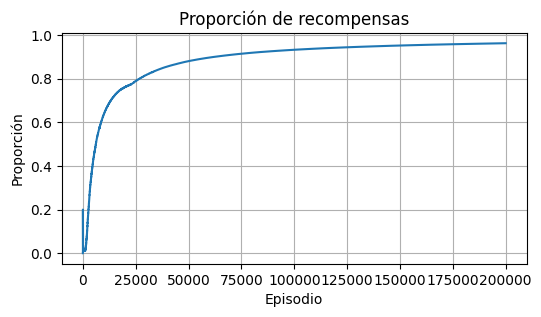

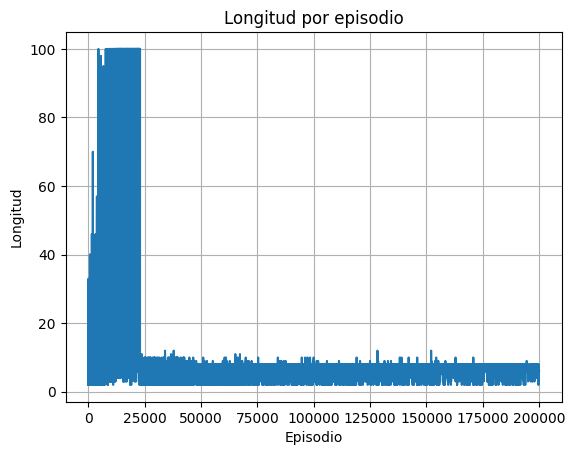

In [5]:
graficar_recompensas(agente_4x4_mc)
graficar_longitud_episodios(agente_4x4_mc)

*MC on-policy*: necesita aproximadamente 100.000 episodios para superar el 90 % de éxito; la curva es ruidosa debido a que la exploración se realiza por episodios completos.


Recompensa total: 1.0
Secuencia de acciones: ['↓', '↓', '→', '↓', '→', '→']

Tabla Q aprendida:


,← Izquierda,↓ Abajo,→ Derecha,↑ Arriba
Estado,,,,
0,0.766,0.974,0.775,0.696
1,0.325,0.000,0.850,0.372
2,0.483,0.874,0.466,0.521
3,0.612,0.000,0.114,0.163
4,0.618,0.983,0.000,0.612
5,0.000,0.000,0.000,0.000
6,0.000,0.952,0.000,0.684
7,0.000,0.000,0.000,0.000
8,0.777,0.000,0.989,0.773



Política óptima aprendida:


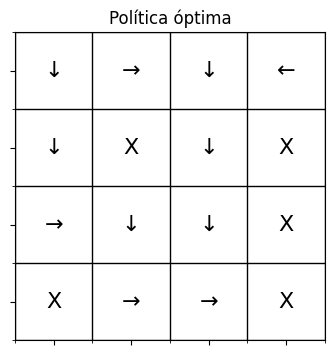

In [6]:
mostrar_resultados_agente(agente_4x4_mc)

## Monte Carlo (Off-Policy)

In [9]:
env_4x4_mc_off = gym.make("FrozenLake-v1", is_slippery=False)
env_4x4_mc_off.reset(seed=SEED)
agente_4x4_mc_off = AgenteMonteCarloOffPolicy(env_4x4_mc_off, epsilon=0.3, discount_factor=1.0)
agente_4x4_mc_off.entrenar(num_episodes=200000)

100%|█████████████████████████████████████████████████████████████████████████| 200000/200000 [03:15<00:00, 1025.56it/s]


array([[0.9551977 , 0.99872759, 0.96831432, 0.99450528],
       [0.97542753, 0.        , 0.9975722 , 0.99117662],
       [0.98189591, 0.99547109, 0.9917148 , 0.99498786],
       [0.9961073 , 0.        , 0.94345621, 0.93099446],
       [0.94821055, 0.99954184, 0.        , 0.99223685],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.99994632, 0.        , 0.99562784],
       [0.        , 0.        , 0.        , 0.        ],
       [0.98092393, 0.        , 0.99978179, 0.99686771],
       [0.99830791, 0.99528493, 0.99997318, 0.        ],
       [0.99976976, 0.99996454, 0.        , 0.98770393],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9968815 , 0.9992408 , 1.        ],
       [0.99955472, 0.99991308, 1.        , 1.        ],
       [0.        , 0.        , 0.        , 0.        ]])

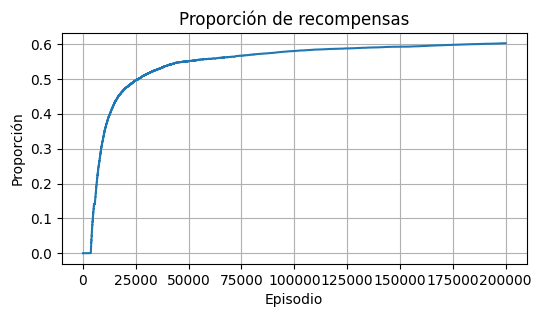

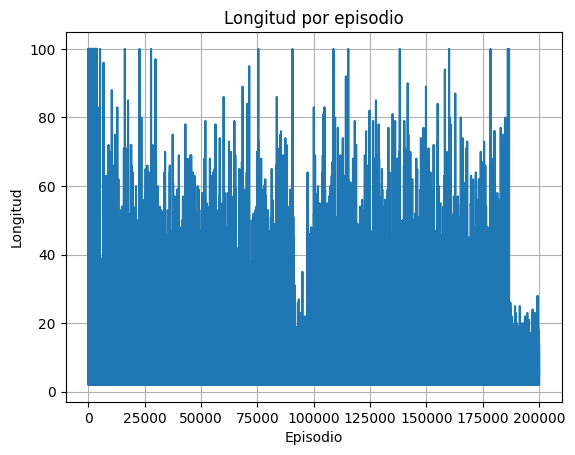

In [10]:
graficar_recompensas(agente_4x4_mc_off)
graficar_longitud_episodios(agente_4x4_mc_off)

*MC off-policy*: necesita aproximadamente 200.000 episodios para superar el 60 % de éxito, no siendo adecuado para este problema.


Recompensa total: 1.0
Secuencia de acciones: ['↓', '↓', '→', '→', '↓', '→']

Tabla Q aprendida:


,← Izquierda,↓ Abajo,→ Derecha,↑ Arriba
Estado,,,,
0,0.955,0.999,0.968,0.995
1,0.975,0.000,0.998,0.991
2,0.982,0.995,0.992,0.995
3,0.996,0.000,0.943,0.931
4,0.948,1.000,0.000,0.992
5,0.000,0.000,0.000,0.000
6,0.000,1.000,0.000,0.996
7,0.000,0.000,0.000,0.000
8,0.981,0.000,1.000,0.997



Política óptima aprendida:


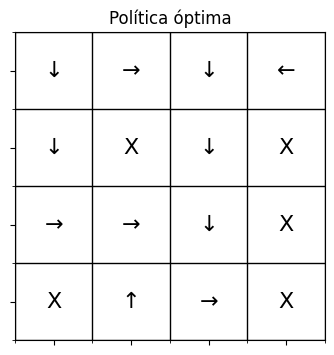

In [11]:
mostrar_resultados_agente(agente_4x4_mc_off)

## SARSA

In [12]:
env_4x4_sarsa = gym.make("FrozenLake-v1", is_slippery=False)
env_4x4_sarsa.reset(seed=SEED)
agente_4x4_sarsa = AgenteSARSA(env_4x4_sarsa, epsilon=0.1, alpha=0.05, discount_factor=0.7, decay=True)
agente_4x4_sarsa.entrenar(num_episodes=200000)

100%|█████████████████████████████████████████████████████████████████████████| 200000/200000 [01:01<00:00, 3269.47it/s]


array([[0.11602062, 0.16731114, 0.15765679, 0.11530848],
       [0.11298071, 0.        , 0.2348531 , 0.16578034],
       [0.16128934, 0.33935844, 0.16401137, 0.23739851],
       [0.23684103, 0.        , 0.03043284, 0.0108334 ],
       [0.16637617, 0.23836482, 0.        , 0.11321891],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.48764443, 0.        , 0.22982781],
       [0.        , 0.        , 0.        , 0.        ],
       [0.23831714, 0.        , 0.33938485, 0.1621732 ],
       [0.23262993, 0.48452645, 0.46111751, 0.        ],
       [0.33622348, 0.69346286, 0.        , 0.33725235],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.48861548, 0.69569172, 0.33121844],
       [0.48336877, 0.69999991, 1.        , 0.47988892],
       [0.        , 0.        , 0.        , 0.        ]])

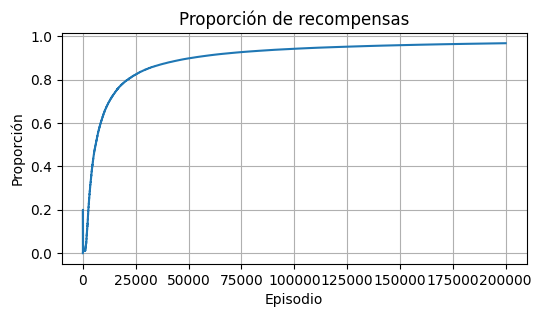

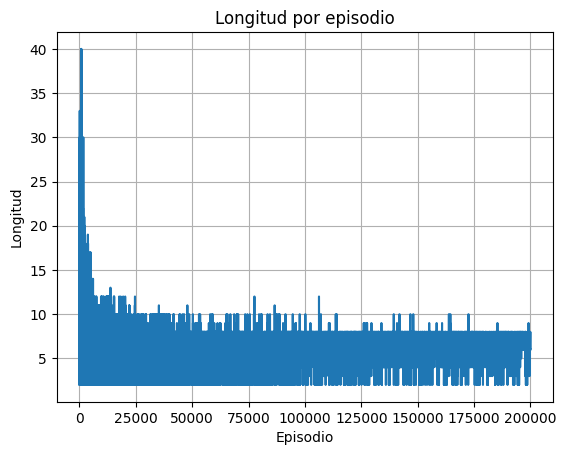

In [13]:
graficar_recompensas(agente_4x4_sarsa)
graficar_longitud_episodios(agente_4x4_sarsa)

*SARSA*: sobrepasa el 95 % de éxito tras aproximadamente 100.000 episodios. La longitud media del episodio cae de unas 12 a unas 2 acciones, lo cual es el comportamiento óptimo.


Recompensa total: 1.0
Secuencia de acciones: ['↓', '↓', '→', '↓', '→', '→']

Tabla Q aprendida:


,← Izquierda,↓ Abajo,→ Derecha,↑ Arriba
Estado,,,,
0,0.116,0.167,0.158,0.115
1,0.113,0.000,0.235,0.166
2,0.161,0.339,0.164,0.237
3,0.237,0.000,0.030,0.011
4,0.166,0.238,0.000,0.113
5,0.000,0.000,0.000,0.000
6,0.000,0.488,0.000,0.230
7,0.000,0.000,0.000,0.000
8,0.238,0.000,0.339,0.162



Política óptima aprendida:


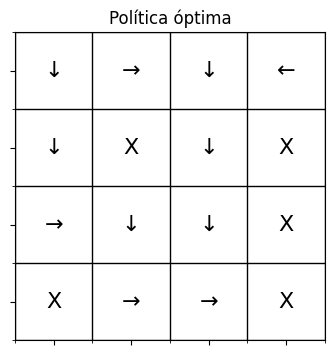

In [14]:
mostrar_resultados_agente(agente_4x4_sarsa)

## Q-Learning

In [15]:
env_4x4_ql = gym.make("FrozenLake-v1", is_slippery=False)
env_4x4_ql.reset(seed=SEED)
agente_4x4_ql = AgenteQLearning(env_4x4_ql, epsilon=0.1, alpha=0.5, discount_factor=0.1, decay=True)
agente_4x4_ql.entrenar(num_episodes=200000)

100%|█████████████████████████████████████████████████████████████████████████| 200000/200000 [01:12<00:00, 2756.10it/s]


array([[1.00000000e-06, 1.00000000e-05, 1.00000000e-05, 1.00000000e-06],
       [1.00000000e-06, 0.00000000e+00, 1.00000000e-04, 1.00000000e-05],
       [1.00000000e-05, 1.00000000e-03, 1.00000000e-05, 1.00000000e-04],
       [1.00000000e-04, 0.00000000e+00, 9.99999913e-06, 9.99999021e-06],
       [1.00000000e-05, 1.00000000e-04, 0.00000000e+00, 1.00000000e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e-02, 0.00000000e+00, 1.00000000e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e-04, 0.00000000e+00, 1.00000000e-03, 1.00000000e-05],
       [1.00000000e-04, 1.00000000e-02, 1.00000000e-02, 0.00000000e+00],
       [1.00000000e-03, 1.00000000e-01, 0.00000000e+00, 1.00000000e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e-02, 1.00000000e

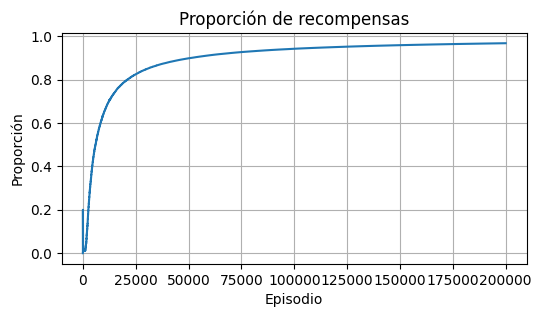

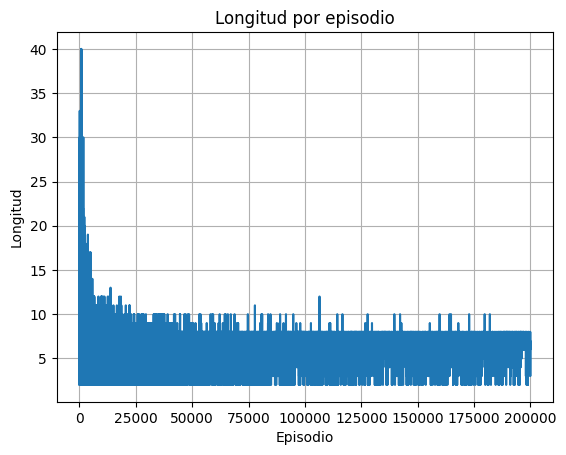

In [16]:
graficar_recompensas(agente_4x4_ql)
graficar_longitud_episodios(agente_4x4_ql)

*Q-Learning*: alcanza el 95 % de éxito ligeramente antes (aproximadamente 125.000 episodios); la sobreestimación no afecta a la política final en este entorno determinista.


Recompensa total: 1.0
Secuencia de acciones: ['↓', '↓', '→', '↓', '→', '→']

Tabla Q aprendida:


,← Izquierda,↓ Abajo,→ Derecha,↑ Arriba
Estado,,,,
0,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000
2,0.000,0.001,0.000,0.000
3,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000
5,0.000,0.000,0.000,0.000
6,0.000,0.010,0.000,0.000
7,0.000,0.000,0.000,0.000
8,0.000,0.000,0.001,0.000



Política óptima aprendida:


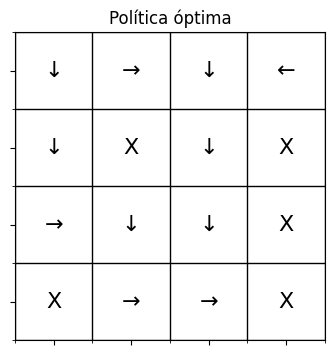

In [17]:
mostrar_resultados_agente(agente_4x4_ql)

# FrozenLake 8x8

## Monte Carlo (On-Policy)

In [18]:
env_8x8_mc = gym.make("FrozenLake-v1", is_slippery=False, map_name="8x8")
env_8x8_mc.reset(seed=SEED)
agente_8x8_mc = AgenteMonteCarlo(env_8x8_mc, epsilon=0.1, decay=True, discount_factor=1.0)
agente_8x8_mc.entrenar(num_episodes=200000)

100%|█████████████████████████████████████████████████████████████████████████| 200000/200000 [02:57<00:00, 1124.80it/s]


array([[0.39846112, 0.40487546, 0.96472903, 0.4057971 ],
       [0.57730479, 0.56471854, 0.97773042, 0.63260922],
       [0.54414042, 0.5545766 , 0.98003529, 0.60254528],
       [0.64940022, 0.63917526, 0.98054916, 0.68364611],
       [0.68947671, 0.71051152, 0.98120931, 0.68981481],
       [0.74195339, 0.73622047, 0.9803815 , 0.74346132],
       [0.74514491, 0.95090248, 0.77350304, 0.73337328],
       [0.43107221, 0.81456044, 0.45496536, 0.43438914],
       [0.10547185, 0.11987626, 0.50402081, 0.11670663],
       [0.26882477, 0.24982001, 0.26781003, 0.61902232],
       [0.11952862, 0.09924812, 0.60547711, 0.10054348],
       [0.16824645, 0.        , 0.21123596, 0.7785562 ],
       [0.21359223, 0.1875    , 0.23666667, 0.74673203],
       [0.38736264, 0.37368421, 0.78508458, 0.35802469],
       [0.73726115, 0.8012959 , 0.9883885 , 0.74631907],
       [0.7812269 , 0.98599274, 0.80334093, 0.78618182],
       [0.09625668, 0.08850727, 0.07133421, 0.33058898],
       [0.32754342, 0.05962521,

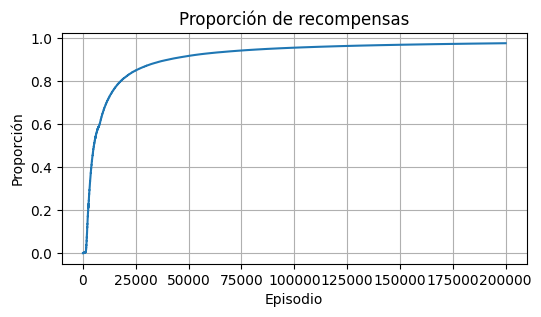

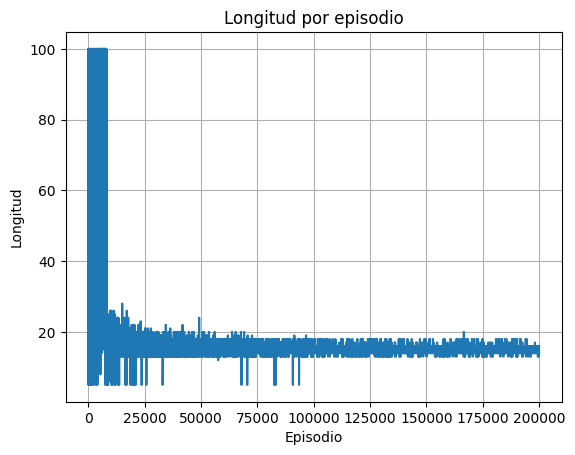

In [19]:
graficar_recompensas(agente_8x8_mc)
graficar_longitud_episodios(agente_8x8_mc)

*MC On-policy*: necesita aproximadamente 100.000 episodios para superar el 95 % de éxito.


Recompensa total: 1.0
Secuencia de acciones: ['→', '→', '→', '→', '→', '→', '↓', '→', '↓', '↓', '↓', '↓', '↓', '↓']

Tabla Q aprendida:


,← Izquierda,↓ Abajo,→ Derecha,↑ Arriba
Estado,,,,
0,0.398,0.405,0.965,0.406
1,0.577,0.565,0.978,0.633
2,0.544,0.555,0.980,0.603
3,0.649,0.639,0.981,0.684
4,0.689,0.711,0.981,0.690
...,...,...,...,...
59,0.000,0.000,0.000,0.000
60,0.000,0.000,0.000,0.000
61,0.000,0.000,0.000,0.000



Política óptima aprendida:


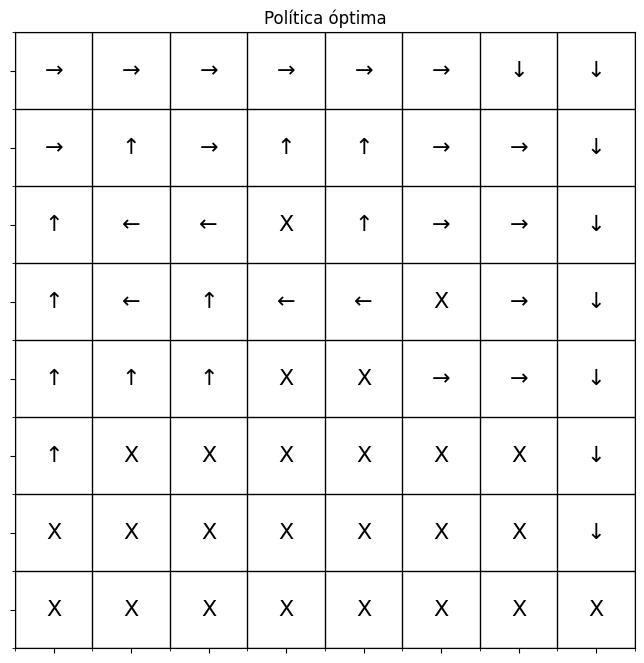

In [20]:
mostrar_resultados_agente(agente_8x8_mc)

## Monte Carlo (Off-Policy)

In [12]:
env_8x8_mc_off = gym.make("FrozenLake-v1", is_slippery=False, map_name="8x8")
env_8x8_mc_off.reset(seed=SEED)
agente_8x8_mc_off = AgenteMonteCarloOffPolicy(env_8x8_mc_off, epsilon=1.0, discount_factor=1.0)
agente_8x8_mc_off.entrenar(num_episodes=200000)

100%|██████████████████████████████████████████████████████████████████████████| 200000/200000 [05:08<00:00, 647.96it/s]


array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.99997562, 0.        , 0.        ],
       [0.999998  , 0.99999966, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        ,

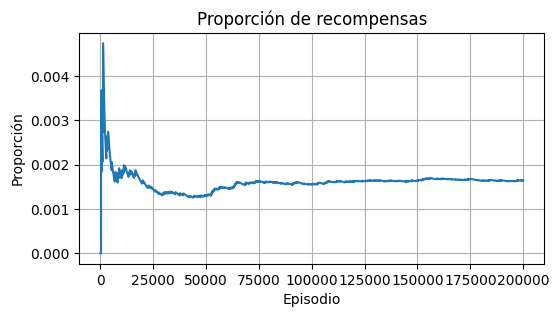

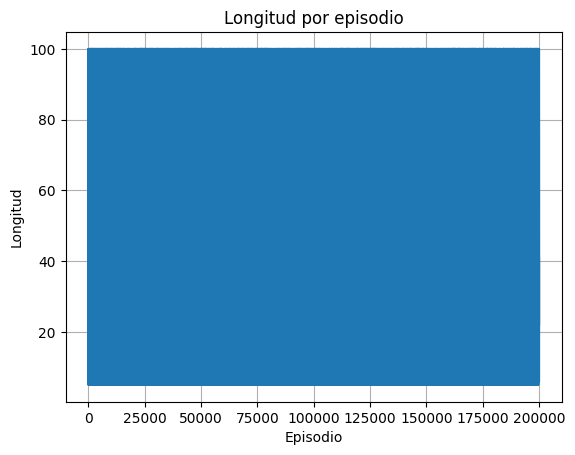

In [13]:
graficar_recompensas(agente_8x8_mc_off)
graficar_longitud_episodios(agente_8x8_mc_off)

*MC off-policy*: en este caso, Monte Carlo Off-Policy no llega a aprender absolutamente nada, ya que se mantiene cerca del 0 % de éxito, con episodios de longitud máxima incluso hasta el episodio 200.000.


🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁
🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁
🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁
🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁
🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁
🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁
🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁
🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁
🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁
🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁
🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁,🤖🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🧊🧊🧊🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🧊🧊🧊🧊🕳️🧊🧊 🧊🧊🧊🕳️🧊🧊🧊🧊 🧊🕳️🕳️🧊🧊🧊🕳️🧊 🧊🕳️🧊🧊🕳️🧊🕳️🧊 🧊🧊🧊🕳️🧊🧊🧊🏁


Recompensa total: 0.0
Secuencia de acciones: ['←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←']

Tabla Q aprendida:


,← Izquierda,↓ Abajo,→ Derecha,↑ Arriba
Estado,,,,
0,0.000,0.0,0.000,0.0
1,0.000,0.0,0.000,0.0
2,0.000,0.0,0.000,0.0
3,0.000,0.0,0.000,0.0
4,0.000,0.0,0.000,0.0
...,...,...,...,...
59,0.000,0.0,0.000,0.0
60,0.000,0.0,1.000,0.0
61,0.877,0.0,0.909,0.0



Política óptima aprendida:


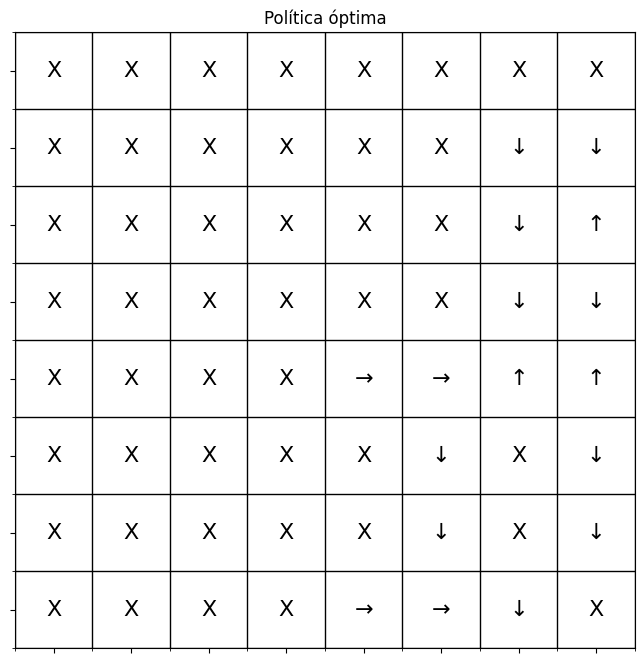

In [14]:
mostrar_resultados_agente(agente_8x8_mc_off)

## SARSA

In [24]:
env_8x8_sarsa = gym.make("FrozenLake-v1", is_slippery=False, map_name="8x8")
env_8x8_sarsa.reset(seed=SEED)
agente_8x8_sarsa = AgenteSARSA(env_8x8_sarsa, epsilon=0.1, alpha=0.05, discount_factor=0.9, decay=True)
agente_8x8_sarsa.entrenar(num_episodes=200000)

100%|██████████████████████████████████████████████████████████████████████████| 200000/200000 [03:22<00:00, 990.09it/s]


array([[2.26787762e-01, 2.46298932e-01, 2.52744639e-01, 2.26913180e-01],
       [2.24642835e-01, 2.73264552e-01, 2.81083123e-01, 2.51966463e-01],
       [2.49635970e-01, 3.06412597e-01, 3.13036274e-01, 2.80231809e-01],
       [2.77388201e-01, 3.35510409e-01, 3.48114616e-01, 3.11600345e-01],
       [3.08537992e-01, 3.80751363e-01, 3.86839496e-01, 3.46483868e-01],
       [3.42655982e-01, 4.21912849e-01, 4.29493734e-01, 3.84741390e-01],
       [3.80546845e-01, 4.76307082e-01, 4.67601881e-01, 4.26758160e-01],
       [2.31032900e-01, 5.27750948e-01, 2.72914022e-01, 3.07865088e-01],
       [1.21989020e-01, 2.53993714e-02, 2.78029622e-01, 1.19248811e-01],
       [1.65244258e-01, 9.28191589e-02, 3.08395786e-01, 1.81427837e-01],
       [2.30751196e-01, 1.56226269e-01, 3.44884126e-01, 2.43695526e-01],
       [2.80436816e-01, 0.00000000e+00, 3.85693122e-01, 2.91177007e-01],
       [3.44818408e-01, 4.19403303e-01, 4.28684022e-01, 3.42390604e-01],
       [3.80776274e-01, 4.67556371e-01, 4.76329246e

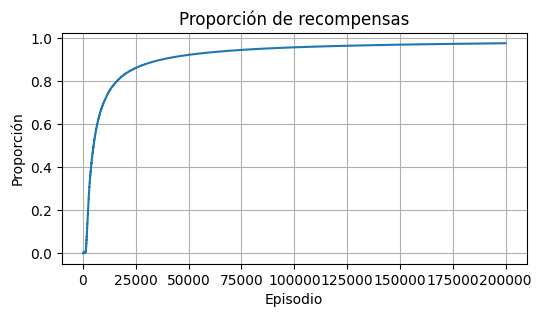

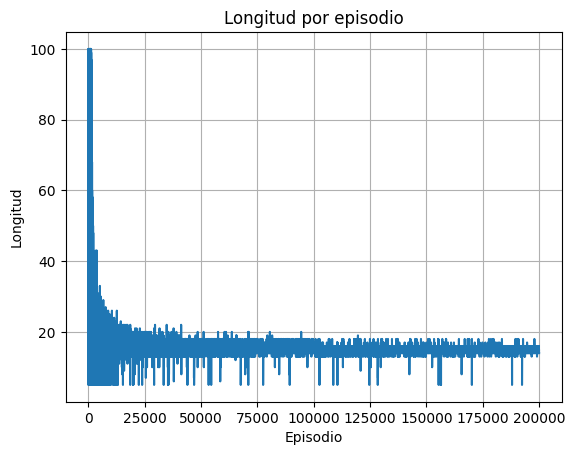

In [25]:
graficar_recompensas(agente_8x8_sarsa)
graficar_longitud_episodios(agente_8x8_sarsa)

- *SARSA*: con la misma configuración alcanza el 90 % de éxito en aproximadamente 75.000 episodios y se estabiliza en un 94 ± 2 % hacia el episodio 100.000.


Recompensa total: 1.0
Secuencia de acciones: ['→', '→', '→', '→', '→', '→', '↓', '→', '↓', '↓', '↓', '↓', '↓', '↓']

Tabla Q aprendida:


,← Izquierda,↓ Abajo,→ Derecha,↑ Arriba
Estado,,,,
0,0.227,0.246,0.253,0.227
1,0.225,0.273,0.281,0.252
2,0.250,0.306,0.313,0.280
3,0.277,0.336,0.348,0.312
4,0.309,0.381,0.387,0.346
...,...,...,...,...
59,0.000,0.000,0.000,0.000
60,0.000,0.000,0.000,0.000
61,0.000,0.000,0.000,0.000



Política óptima aprendida:


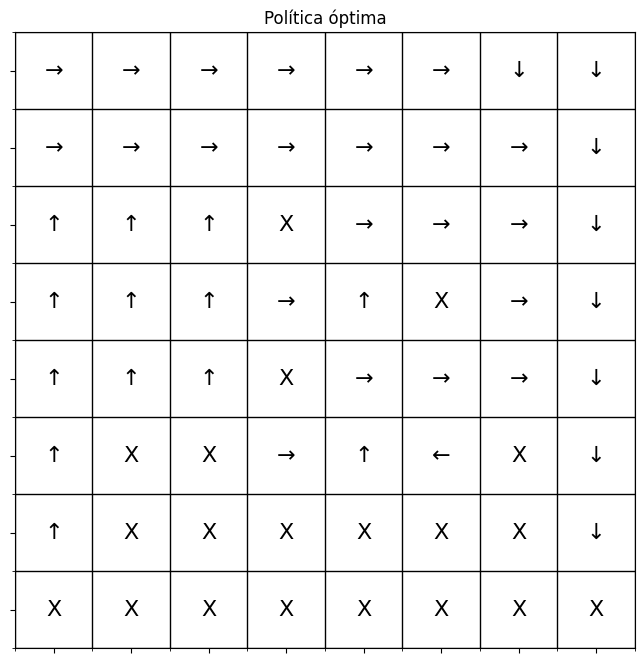

In [26]:
mostrar_resultados_agente(agente_8x8_sarsa)

## Q-Learning

In [27]:
env_8x8_ql = gym.make("FrozenLake-v1", is_slippery=False, map_name="8x8")
env_8x8_ql.reset(seed=SEED)
agente_8x8_ql = AgenteQLearning(env_8x8_ql, epsilon=0.1, alpha=0.05, discount_factor=1.0, decay=True)
agente_8x8_ql.entrenar(num_episodes=200000)

100%|██████████████████████████████████████████████████████████████████████████| 200000/200000 [03:40<00:00, 906.11it/s]


array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [9.82338597e-01, 1.00000000e+00, 9.94869844e-01, 9.94393734e-01],
       [9.53015087e-01, 1.00000000e+00, 9.27298940e-01, 9.14341941e-01],
       [9.25421284e-01, 1.00000000e+00, 8.95900198e-01, 8.18222837e-01],
       [9.27471984e-01, 1.00000000e+00, 9.41592186e-01, 8.88967139e-01],
       [9.17291692e-01, 1.00000000e+00, 9.10371532e-01, 9.38536207e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e

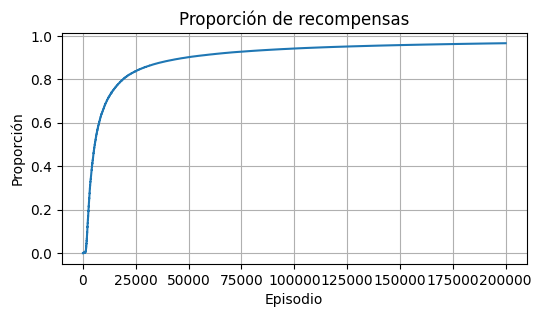

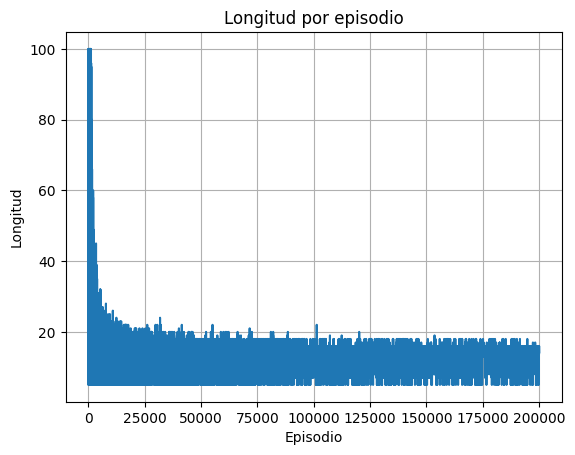

In [28]:
graficar_recompensas(agente_8x8_ql)
graficar_longitud_episodios(agente_8x8_ql)

*Q-Learning*: propaga más rápido la recompensa terminal: alcanza el 95 % de éxito en el episodio 4.000 y se estabiliza en un 98 ± 1 % hacia el episodio 200.000.


Recompensa total: 1.0
Secuencia de acciones: ['↓', '→', '→', '→', '→', '↓', '→', '→', '↓', '→', '↓', '↓', '↓', '↓']

Tabla Q aprendida:


,← Izquierda,↓ Abajo,→ Derecha,↑ Arriba
Estado,,,,
0,1.000,1.0,1.000,1.000
1,1.000,1.0,1.000,1.000
2,1.000,1.0,1.000,1.000
3,0.982,1.0,0.995,0.994
4,0.953,1.0,0.927,0.914
...,...,...,...,...
59,0.000,0.0,0.000,0.000
60,0.000,0.0,0.000,0.000
61,0.000,0.0,0.000,0.000



Política óptima aprendida:


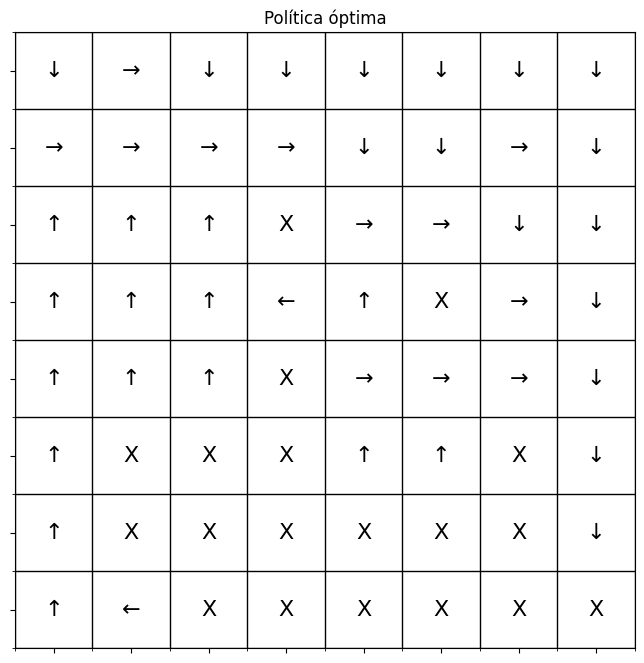

In [29]:
mostrar_resultados_agente(agente_8x8_ql)